In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pycaret.regression import *

# Load the datasets
hour_data = pd.read_csv('hour.csv')
day_data = pd.read_csv('day.csv')


In [2]:
# Preprocesarea datelor
# a) Vizualizarea primelor rânduri ale seturilor de date
print(hour_data.head())
print(day_data.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01   

In [3]:
pip install  streamlit

Note: you may need to restart the kernel to use updated packages.


In [4]:
# b) Vizualizarea statisticilor descriptive
print(hour_data.describe())
print(day_data.describe())

          instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.

In [5]:
# c) Tratarea valorilor lipsă
print("Missing values in hour_data:")
print(hour_data.isnull().sum())
print("Missing values in day_data:")
print(day_data.isnull().sum())


Missing values in hour_data:
instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64
Missing values in day_data:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [6]:
# d) Detectarea și eliminarea outlierilor
# Definim o funcție pentru eliminarea outlierilor bazată pe IQR

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicăm funcția pentru coloanele numerice
for col in ['casual', 'registered', 'cnt']:
    day_data = remove_outliers(day_data, col)
    hour_data = remove_outliers(hour_data, col)

# Agregarea datelor orare la nivel de zi
hourly_grouped = hour_data.groupby('dteday').agg({
    'casual': 'sum',
    'registered': 'sum'
}).reset_index()

# Îmbinarea setului de date zilnic cu datele agregate
merged_data = pd.merge(day_data, hourly_grouped, on='dteday', suffixes=('_daily', '_hourly'))

# Crearea etichetei 'rider_type'
merged_data['rider_type'] = merged_data.apply(
    lambda row: 'registered' if row['registered_hourly'] > row['casual_hourly'] else 'casual', axis=1
)

# Eliminarea coloanelor redundante
merged_data.drop(columns=['dteday', 'instant', 'casual_daily', 'registered_daily', 'casual_hourly', 'registered_hourly'], inplace=True)

# Împărțirea în seturi de antrenament și testare
train, test = train_test_split(merged_data, test_size=0.3, random_state=1, stratify=merged_data['rider_type'])

# Configurarea PyCaret pentru regresie
reg_setup = setup(data=train, target='cnt', remove_outliers=True, remove_multicollinearity=True)

# Compararea modelelor și alegerea celui mai bun
best_reg_model = compare_models()

# Crearea și finalizarea celui mai bun model
final_reg_model = finalize_model(best_reg_model)

# Realizarea predicțiilor pe setul de testare
predictions = predict_model(final_reg_model, data=test)
print(predictions.head())

,Description,Value
0,Session id,8273
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(480, 13)"
4,Transformed data shape,"(463, 12)"
5,Transformed train set shape,"(319, 12)"
6,Transformed test set shape,"(144, 12)"
7,Numeric features,11
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,484.2230,516323.5114,699.8562,0.8448,0.3109,0.7769,0.1190
gbr,Gradient Boosting Regressor,497.7972,513321.1759,702.2773,0.8448,0.3033,0.7183,0.0920
lightgbm,Light Gradient Boosting Machine,526.5732,564764.6442,738.7652,0.8283,0.3181,0.7538,0.0930
rf,Random Forest Regressor,520.5329,583365.0647,743.4800,0.8246,0.3237,0.7867,0.1350
lr,Linear Regression,603.5278,657042.0824,803.0562,0.7993,0.3403,0.7348,1.1030
lasso,Lasso Regression,603.6476,657313.5275,803.4040,0.7992,0.3308,0.7405,0.0640
llar,Lasso Least Angle Regression,603.6905,657371.8430,803.4406,0.7992,0.3308,0.7406,0.0650
br,Bayesian Ridge,604.9973,657895.2924,803.8091,0.7991,0.3399,0.7413,0.0760
huber,Huber Regressor,596.5566,665022.4824,806.9148,0.7964,0.3475,0.7561,0.0650
lar,Least Angle Regression,612.8096,675881.7628,814.2317,0.7930,0.3456,0.7388,0.0650


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,467.7083,461616.7691,679.4239,0.8734,0.2427,0.1690


     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
642       4   1    11        0        6           0           1  0.325000   
391       1   1     2        0        4           1           2  0.399167   
275       4   0    10        0        6           0           1  0.521667   
476       2   1     5        0        0           0           2  0.562500   
638       4   1    11        0        2           1           2  0.343333   

        atemp       hum  windspeed  rider_type   cnt  prediction_label  
642  0.326383  0.545417   0.179729  registered  5629           5903.20  
391  0.398971  0.672917   0.187187  registered  3761           4235.49  
275  0.513242  0.701250   0.045404  registered  5409           5041.27  
476  0.546737  0.740000   0.149879  registered  6359           4650.58  
638  0.323225  0.662917   0.342046  registered  4094           4252.46  


In [7]:
# Elaborarea mai multor modele de regresie și evaluarea lor
# a) Modelul de regresie liniară
linear_model = create_model('lr')
linear_predictions = predict_model(linear_model, data=test)
print("Linear Regression Predictions:")
print(linear_predictions.head())

# b) Modelul k-NN
knn_model = create_model('knn')
knn_predictions = predict_model(knn_model, data=test)
print("K-NN Regression Predictions:")
print(knn_predictions.head())

# Compararea modelelor și alegerea celui mai bun
best_reg_model = compare_models()

# Crearea și finalizarea celui mai bun model
final_reg_model = finalize_model(best_reg_model)

# Realizarea predicțiilor pe setul de testare
predictions = predict_model(final_reg_model, data=test)
print(predictions.head())

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,567.2934,575160.0410,758.3931,0.8160,0.2409,0.1598
1,595.7665,638133.8156,798.8328,0.7887,0.2559,0.2214
2,616.5069,902854.3985,950.1865,0.7625,0.9318,5.5602
3,655.8647,639666.3363,799.7914,0.8183,0.4616,0.1849
4,643.6964,884298.4162,940.3714,0.6774,0.3214,0.2584
5,611.9107,584353.2875,764.4300,0.8556,0.3345,0.2662
6,537.0025,599117.6257,774.0269,0.7848,0.1451,0.1208
7,757.8898,793163.1740,890.5971,0.7871,0.2274,0.2024
8,615.5297,661255.7481,813.1763,0.7865,0.3264,0.2591


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,693.8761,812155.9822,901.1970,0.7773,0.3071,0.2233


Linear Regression Predictions:
     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
642       4   1    11        0        6           0           1  0.325000   
391       1   1     2        0        4           1           2  0.399167   
275       4   0    10        0        6           0           1  0.521667   
476       2   1     5        0        0           0           2  0.562500   
638       4   1    11        0        2           1           2  0.343333   

        atemp       hum  windspeed  rider_type   cnt  prediction_label  
642  0.326383  0.545417   0.179729  registered  5629       5256.563590  
391  0.398971  0.672917   0.187187  registered  3761       4198.155748  
275  0.513242  0.701250   0.045404  registered  5409       4746.741322  
476  0.546737  0.740000   0.149879  registered  6359       4826.984062  
638  0.323225  0.662917   0.342046  registered  4094       4199.252925  


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,685.1824,653164.1188,808.1857,0.7910,0.2354,0.2006
1,815.9941,1401381.2482,1183.7995,0.5361,0.5010,0.4957
2,880.6824,1360975.3788,1166.6085,0.6420,0.9138,5.0045
3,769.7118,909968.8529,953.9229,0.7416,0.2914,0.2462
4,694.9000,1149510.5094,1072.1523,0.5806,0.3824,0.3354
5,715.7824,776798.4694,881.3617,0.8080,0.4000,0.3564
6,518.8727,500809.5515,707.6790,0.8201,0.1561,0.1219
7,952.0000,1479333.6824,1216.2786,0.6029,0.3778,0.3392
8,894.5515,1369927.6788,1170.4391,0.5576,0.4536,0.4204


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,814.1913,1125765.8462,1061.0211,0.6914,0.3442,0.2898


K-NN Regression Predictions:
     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
642       4   1    11        0        6           0           1  0.325000   
391       1   1     2        0        4           1           2  0.399167   
275       4   0    10        0        6           0           1  0.521667   
476       2   1     5        0        0           0           2  0.562500   
638       4   1    11        0        2           1           2  0.343333   

        atemp       hum  windspeed  rider_type   cnt  prediction_label  
642  0.326383  0.545417   0.179729  registered  5629            4882.6  
391  0.398971  0.672917   0.187187  registered  3761            4022.0  
275  0.513242  0.701250   0.045404  registered  5409            4214.2  
476  0.546737  0.740000   0.149879  registered  6359            4166.4  
638  0.323225  0.662917   0.342046  registered  4094            3818.4  


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,484.2230,516323.5114,699.8562,0.8448,0.3109,0.7769,0.0980
gbr,Gradient Boosting Regressor,497.7972,513321.1759,702.2773,0.8448,0.3033,0.7183,0.0850
lightgbm,Light Gradient Boosting Machine,526.5732,564764.6442,738.7652,0.8283,0.3181,0.7538,0.0810
rf,Random Forest Regressor,520.5329,583365.0647,743.4800,0.8246,0.3237,0.7867,0.1170
lr,Linear Regression,603.5278,657042.0824,803.0562,0.7993,0.3403,0.7348,0.0580
lasso,Lasso Regression,603.6476,657313.5275,803.4040,0.7992,0.3308,0.7405,0.0610
llar,Lasso Least Angle Regression,603.6905,657371.8430,803.4406,0.7992,0.3308,0.7406,0.0610
br,Bayesian Ridge,604.9973,657895.2924,803.8091,0.7991,0.3399,0.7413,0.0630
huber,Huber Regressor,596.5566,665022.4824,806.9148,0.7964,0.3475,0.7561,0.0760
lar,Least Angle Regression,612.8096,675881.7628,814.2317,0.7930,0.3456,0.7388,0.0620


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,467.7083,461616.7691,679.4239,0.8734,0.2427,0.1690


     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
642       4   1    11        0        6           0           1  0.325000   
391       1   1     2        0        4           1           2  0.399167   
275       4   0    10        0        6           0           1  0.521667   
476       2   1     5        0        0           0           2  0.562500   
638       4   1    11        0        2           1           2  0.343333   

        atemp       hum  windspeed  rider_type   cnt  prediction_label  
642  0.326383  0.545417   0.179729  registered  5629           5903.20  
391  0.398971  0.672917   0.187187  registered  3761           4235.49  
275  0.513242  0.701250   0.045404  registered  5409           5041.27  
476  0.546737  0.740000   0.149879  registered  6359           4650.58  
638  0.323225  0.662917   0.342046  registered  4094           4252.46  


In [8]:
# Compararea performanțelor modelelor
evaluate_models = pull()
print("Model Performance Comparison:")
print(evaluate_models)

Model Performance Comparison:
                   Model       MAE          MSE      RMSE      R2   RMSLE  \
0  Extra Trees Regressor  467.7083  461616.7691  679.4239  0.8734  0.2427   

    MAPE  
0  0.169  


In [9]:
import streamlit as st

# Interfață Streamlit
st.title("Analiza modelelor de regresie")
st.subheader("Predicții pentru regresia liniară")
st.write(linear_predictions.head())

st.subheader("Predicții pentru k-NN")
st.write(knn_predictions.head())

st.subheader("Comparația modelelor")
st.write(evaluate_models)


2025-02-20 17:13:39.873 
  command:

    streamlit run C:\Users\Mihai\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [10]:
# Aggregate the hourly data by day
hourly_grouped = hour_data.groupby('dteday').agg({
    'casual': 'sum',
    'registered': 'sum'
}).reset_index()

# Merge the aggregated hourly data with the daily data
merged_data = pd.merge(day_data, hourly_grouped, on='dteday', suffixes=('_daily', '_hourly'))
df = merged_data
# Check the first few rows of the merged data to ensure it's correct
print(df.head())

print(df.info())

print(df.isnull().sum())


   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual_daily  \
0           2  0.344167  0.363625  0.805833   0.160446           331   
1           2  0.363478  0.353739  0.696087   0.248539           131   
2           1  0.196364  0.189405  0.437273   0.248309           120   
3           1  0.200000  0.212122  0.590435   0.160296           108   
4           1  0.226957  0.229270  0.436957   0.186900            82   

   registered_daily   cnt  casual_hourly  registered_hourly  
0               654   985            331                654 

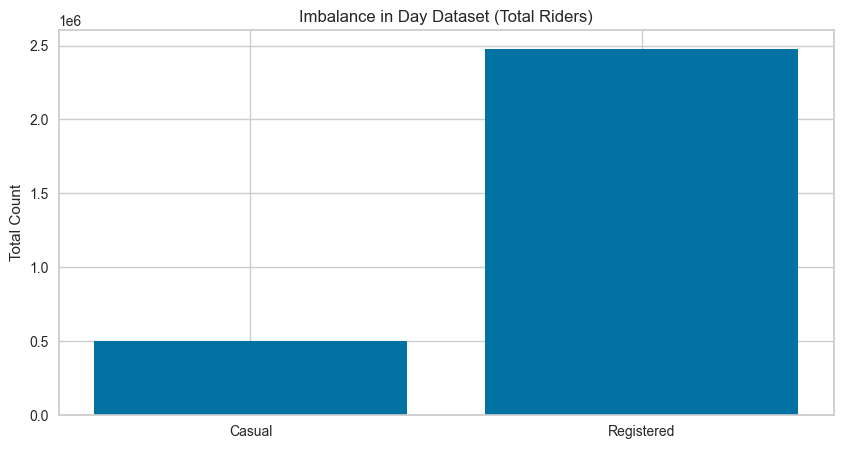

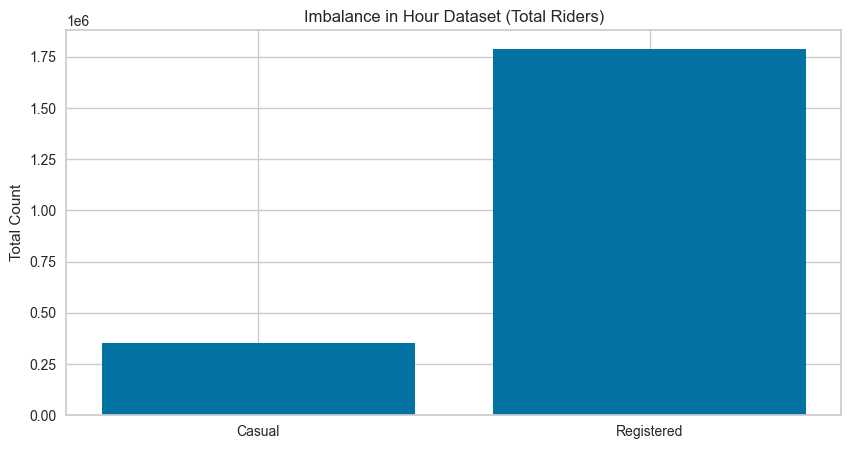

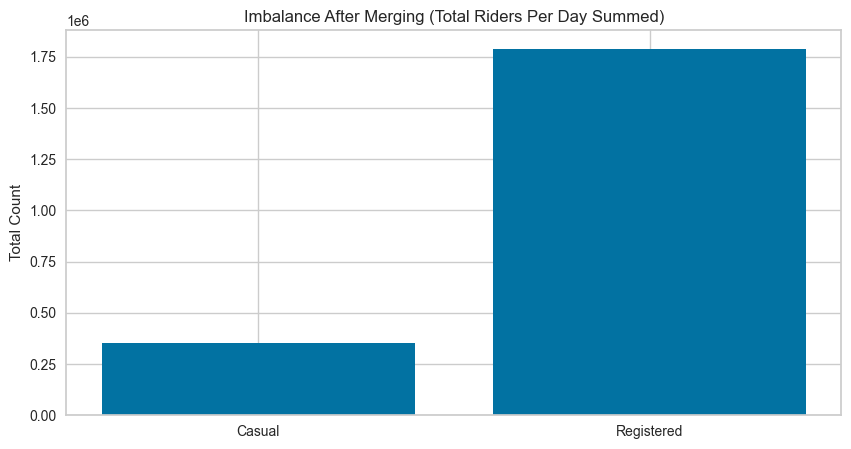

In [11]:
# Imbalance Analysis Plots
import matplotlib.pyplot as plt

# Plot the imbalance in the day dataset
plt.figure(figsize=(10, 5))
plt.bar(["Casual", "Registered"], [day_data["casual"].sum(), day_data["registered"].sum()])
plt.title("Imbalance in Day Dataset (Total Riders)")
plt.ylabel("Total Count")
plt.show()

# Plot the imbalance in the hour dataset
plt.figure(figsize=(10, 5))
plt.bar(["Casual", "Registered"], [hour_data["casual"].sum(), hour_data["registered"].sum()])
plt.title("Imbalance in Hour Dataset (Total Riders)")
plt.ylabel("Total Count")
plt.show()

# Merge datasets on date (dteday) by summing up hourly data to daily level
merged_df = hour_data.groupby("dteday")[["casual", "registered"]].sum().reset_index()

# Plot the imbalance after merging
plt.figure(figsize=(10, 5))
plt.bar(["Casual", "Registered"], [merged_df["casual"].sum(), merged_df["registered"].sum()])
plt.title("Imbalance After Merging (Total Riders Per Day Summed)")
plt.ylabel("Total Count")
plt.show()


In [12]:
from sklearn.model_selection import train_test_split

# Compute rider_type before dropping columns
merged_data['rider_type'] = merged_data.apply(
    lambda row: 'registered' if row['registered_hourly'] > row['casual_hourly'] else 'casual', axis=1
)

# Drop any potential leakage columns
df = merged_data.drop(columns=['dteday', 'instant', 'casual_daily', 'registered_daily', 
                               'casual_hourly', 'registered_hourly'])

# Verify feature set before training
print(df.columns)

# Split into training and testing sets (80-20 split)
train, test = train_test_split(df, test_size=0.3, random_state=1, stratify=df['rider_type'])

# Display the shape of the split data
print(train.shape, test.shape)


Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'rider_type'],
      dtype='object')
(480, 13) (207, 13)


In [13]:
from pycaret.regression import *

# Setup PyCaret for model comparison with outlier removal disabled
reg_setup = setup(data=train, target='cnt', remove_outliers=False, remove_multicollinearity=True)

# Compare models and choose the best one
best_reg_model = compare_models()

# Create and finalize the best model
final_reg_model = finalize_model(best_reg_model)

# Make predictions on the test set
predictions = predict_model(final_reg_model, data=test)

# Display the results
print(predictions.head())

# Check dataset shape after setup to verify row count
print(get_config('X').shape)

test_predictions = predict_model(final_reg_model, data=test)
print(test_predictions.head())

get_config('X').columns



,Description,Value
0,Session id,3532
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(480, 13)"
4,Transformed data shape,"(480, 12)"
5,Transformed train set shape,"(336, 12)"
6,Transformed test set shape,"(144, 12)"
7,Numeric features,11
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,471.9361,449772.6390,651.5812,0.8371,0.2760,0.7007,0.0390
lightgbm,Light Gradient Boosting Machine,477.3006,456306.0787,657.1725,0.8359,0.2815,0.6963,0.0440
et,Extra Trees Regressor,433.6156,451762.2562,643.0425,0.8345,0.2759,0.7677,0.0590
rf,Random Forest Regressor,468.3127,490537.3167,671.0151,0.8203,0.2895,0.8342,0.0790
lr,Linear Regression,595.5128,649881.2172,797.3124,0.7713,0.2969,0.7694,0.0170
lasso,Lasso Regression,594.8901,649247.7237,796.9619,0.7713,0.2971,0.7765,0.0170
llar,Lasso Least Angle Regression,594.9021,649280.5765,796.9861,0.7713,0.2971,0.7765,0.0200
br,Bayesian Ridge,596.6105,650971.4735,798.1260,0.7708,0.2978,0.7788,0.0200
huber,Huber Regressor,587.6803,654043.7589,796.4361,0.7683,0.2972,0.7977,0.0250
ridge,Ridge Regression,609.8404,668156.9934,808.9481,0.7643,0.3038,0.8129,0.0170


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,504.6336,485857.1381,697.0345,0.8668,0.2306,0.1671


     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
642       4   1    11        0        6           0           1  0.325000   
391       1   1     2        0        4           1           2  0.399167   
275       4   0    10        0        6           0           1  0.521667   
476       2   1     5        0        0           0           2  0.562500   
638       4   1    11        0        2           1           2  0.343333   

        atemp       hum  windspeed  rider_type   cnt  prediction_label  
642  0.326383  0.545417   0.179729  registered  5629       4931.267046  
391  0.398971  0.672917   0.187187  registered  3761       4289.285960  
275  0.513242  0.701250   0.045404  registered  5409       4951.844454  
476  0.546737  0.740000   0.149879  registered  6359       5958.193518  
638  0.323225  0.662917   0.342046  registered  4094       4197.187433  
(480, 12)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,504.6336,485857.1381,697.0345,0.8668,0.2306,0.1671


     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
642       4   1    11        0        6           0           1  0.325000   
391       1   1     2        0        4           1           2  0.399167   
275       4   0    10        0        6           0           1  0.521667   
476       2   1     5        0        0           0           2  0.562500   
638       4   1    11        0        2           1           2  0.343333   

        atemp       hum  windspeed  rider_type   cnt  prediction_label  
642  0.326383  0.545417   0.179729  registered  5629       4931.267046  
391  0.398971  0.672917   0.187187  registered  3761       4289.285960  
275  0.513242  0.701250   0.045404  registered  5409       4951.844454  
476  0.546737  0.740000   0.149879  registered  6359       5958.193518  
638  0.323225  0.662917   0.342046  registered  4094       4197.187433  


Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'rider_type'],
      dtype='object')

In [14]:
# Creating models for the best estimators
lgbm = create_model('lightgbm')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,649.4950,869372.5234,932.4015,0.7250,0.4208,0.3752
1,586.0821,549727.5333,741.4361,0.8029,0.2321,0.1747
2,419.4421,303438.8432,550.8528,0.8655,0.1876,0.1217
3,443.5018,297566.2991,545.4964,0.9188,0.2263,0.1692
4,553.7359,694179.4127,833.1743,0.7379,0.2676,0.1895
5,452.1182,310104.6365,556.8704,0.9060,0.1638,0.1205
6,359.4372,210379.0450,458.6710,0.9443,0.1341,0.0987
7,418.4616,280544.3528,529.6644,0.8790,0.1180,0.0989
8,421.0876,335449.3667,579.1799,0.9172,0.1553,0.1132


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
# Finaliszing model for predictions
model = finalize_model(lgbm)
predictions = predict_model(model, data = test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,474.6776,443082.5090,665.6444,0.8785,0.2225,0.1590
